<a href="https://colab.research.google.com/github/EmanuelSilva69/todasasatividadesdetreino/blob/main/Untitled11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gerar o Pointcloud por uma imagem (edite o nome no 2º bloco)

In [2]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
!pip install opencv-python-headless
import cv2
import numpy as np
from PIL import Image

# --- Carregue sua imagem ---
img_path = "/content/pngtree-a-classic-wooden-chair-png-image_13901878.png" # Troque pelo seu caminho
img_pil = Image.open(img_path).convert("RGB")
img_cv = np.array(img_pil)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR) # Converte PIL(RGB) para OpenCV(BGR)

# --- Crie a Máscara ---
# Se for fundo verde (chroma key)
hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
lower_green = np.array([35, 100, 100])
upper_green = np.array([85, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)
# Inverte a máscara (queremos a cadeira, não o fundo)
mask = cv2.bitwise_not(mask)

# --- Aplique a Máscara na Imagem Original (para o MiDaS) ---
# Isso "apaga" o fundo, ajudando o MiDaS a focar no objeto
img_masked_np = cv2.bitwise_and(img_cv, img_cv, mask=mask)
# Converte de volta para PIL/Numpy (RGB) para o MiDaS
img_masked_pil = Image.fromarray(cv2.cvtColor(img_masked_np, cv2.COLOR_BGR2RGB))
img_np = np.array(img_masked_pil) # <--- USE ESSA VARIÁVEL 'img_np' NO MiDaS

# Salve a máscara para usar depois com o Open3D
cv2.imwrite("/content/mask.png", mask)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


True

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


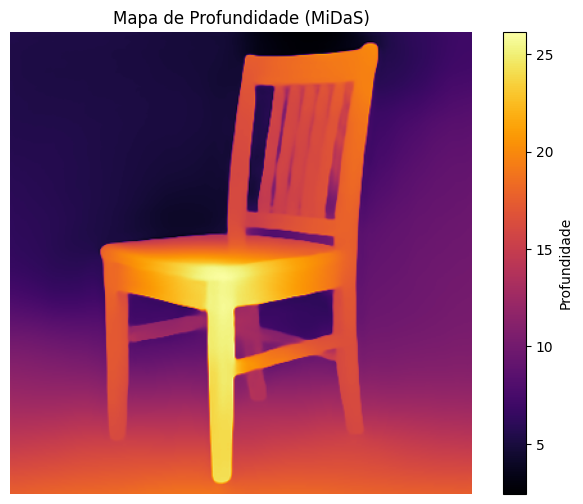

In [4]:
import torch
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

# ======================================================
# 🧠 Carregar modelo MiDaS
# ======================================================
model_type = "DPT_Large"  # ou "DPT_Hybrid" se quiser mais leve
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

device = "cuda" if torch.cuda.is_available() else "cpu"
midas.to(device)
midas.eval()

# ======================================================
# 🖼️ Carregar e preparar imagem
# ======================================================
img_path = "/content/pngtree-a-classic-wooden-chair-png-image_13901878.png" #Aqui oh !!
img = Image.open(img_path).convert("RGB")   # 🔹 garante formato RGB

# Converter para NumPy (float32)
img_np = np.array(img)
input_batch = midas_transforms.dpt_transform(img_np).to(device)

# ======================================================
# 🔮 Inferência: gerar mapa de profundidade
# ======================================================
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth = prediction.cpu().numpy()

# ======================================================
# 🎨 Mostrar o mapa de profundidade
# ======================================================
plt.figure(figsize=(8, 6))
plt.imshow(depth, cmap="inferno")
plt.colorbar(label="Profundidade")
plt.title("Mapa de Profundidade (MiDaS)")
plt.axis("off")
plt.show()


In [5]:
import open3d as o3d
import numpy as np

# Normaliza a profundidade gerada pelo MiDaS
depth_np = (depth - depth.min()) / (depth.max() - depth.min())

# Cria imagens Open3D de profundidade e cor
depth_o3d = o3d.geometry.Image((depth_np * 1000).astype(np.uint16))
color_o3d = o3d.geometry.Image(np.array(img))

# Combina em um RGBD Image
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d,
    depth_o3d,
    depth_scale=1000.0,
    depth_trunc=3.0,
    convert_rgb_to_intensity=False
)

# Parâmetros de câmera genéricos
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault
)

# Cria o point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

# Corrige orientação (MiDaS inverte o eixo vertical)
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

# Salva a nuvem
o3d.io.write_point_cloud("/content/image_pointcloud.ply", pcd)
print("✅ Point Cloud gerada e salva em: /content/image_pointcloud.ply")

✅ Point Cloud gerada e salva em: /content/image_pointcloud.ply


## Fazer a mesh

In [6]:
# ======================================================
# ⚙️ Otimizar nuvem e criar malha 3D
# ======================================================
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt



In [7]:
# Carregue a máscara que salvamos
mask_cv = cv2.imread("/content/mask.png", cv2.IMREAD_GRAYSCALE)

# Redimensione a máscara para ter o mesmo tamanho do mapa de profundidade
mask_resized = cv2.resize(mask_cv, (depth.shape[1], depth.shape[0]))

# Aplique a máscara: Zere a profundidade de todos os pixels do fundo
depth_masked = depth * (mask_resized / 255.0) # (mask / 255.0) vira 0 ou 1

# --- Agora use 'depth_masked' no Open3D ---
depth_o3d = o3d.geometry.Image((depth_masked * 1000).astype(np.uint16))
color_o3d = o3d.geometry.Image(np.array(img_pil)) # Use a imagem original colorida

In [8]:
#  1. (Opcional) Reduzir pontos para não travar o Colab
pcd_down = pcd.voxel_down_sample(voxel_size=0.005)
print(f"✅ Nuvem reduzida de {len(pcd.points)} para {len(pcd_down.points)} pontos")
# ------------------------------------------------------------
# NOVO BLOCO: Limpeza da Nuvem de Pontos (RANSAC + DBSCAN)
# ------------------------------------------------------------
print("Pontos antes da limpeza:", len(pcd_down.points))

# 1. RANSAC para remover o plano (o "chão")
try:
    plane_model, inliers = pcd_down.segment_plane(distance_threshold=0.02,
                                             ransac_n=3,
                                             num_iterations=1000)
    # Seleciona os pontos que NÃO são o chão
    pcd_no_floor = pcd_down.select_by_index(inliers, invert=True)
    print("Pontos após remover o chão:", len(pcd_no_floor.points))
except Exception as e:
    print(f"RANSAC falhou (provavelmente não achou um plano): {e}")
    pcd_no_floor = pcd_down # Segue em frente sem remover o chão

# 2. Clustering (DBSCAN) para remover ruído e focar no objeto principal
labels = np.array(pcd_no_floor.cluster_dbscan(eps=0.05, min_points=10, print_progress=True))

if (labels.max() > -1): # Se encontrou algum cluster
    counts = np.bincount(labels[labels != -1]) # Ignora ruído (label -1)
    largest_cluster_label = np.argmax(counts)

    # Seleciona apenas os pontos do maior cluster (a cadeira)
    pcd_clean = pcd_no_floor.select_by_index(np.where(labels == largest_cluster_label)[0])
    print("Pontos após limpeza final (DBSCAN):", len(pcd_clean.points))
else:
    print("DBSCAN não encontrou clusters, usando nuvem sem chão.")
    pcd_clean = pcd_no_floor

# ------------------------------------------------------------
# 3. Estimar normais (AGORA USANDO A NUVEM LIMPA)
# ------------------------------------------------------------
# !! IMPORTANTE: Troque 'pcd_down' por 'pcd_clean' !!
pcd_clean.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
    radius=0.1, max_nn=100))
pcd_clean.orient_normals_consistent_tangent_plane(k=30)

# E continue o resto do código usando 'pcd_clean'...
# mesh_poisson, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_clean, ...)

✅ Nuvem reduzida de 129590 para 19007 pontos
Pontos antes da limpeza: 19007
Pontos após remover o chão: 12172
Pontos após limpeza final (DBSCAN): 12114


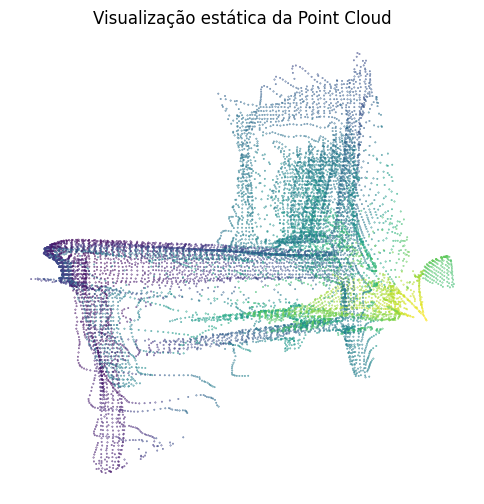

In [9]:



#  2. Mostrar visualização estática (rápida)
points = np.asarray(pcd_clean.points)
plt.figure(figsize=(6,6))
plt.scatter(points[:, 0], points[:, 1], s=0.1, c=points[:, 2], cmap='viridis')
plt.title("Visualização estática da Point Cloud")
plt.axis("off")
plt.show()

#  3. Estimar normais (necessário para reconstrução)
pcd_clean.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
    radius=0.1, max_nn=100))
pcd_clean.orient_normals_consistent_tangent_plane(k=30)





Iniciando reconstrução Poisson (pode demorar)...
✅ Malha Poisson gerada e cortada.
 Malha 3D gerada e salva em: /content/image_mesh_poisson.ply


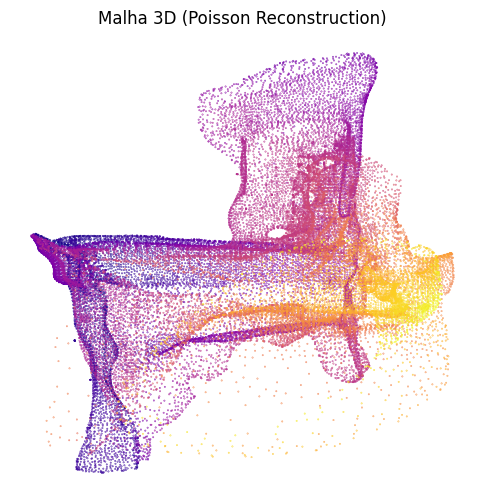

In [10]:
## ------------------------------------------------------------
# 4️⃣ Criar malha via Poisson (usando a nuvem limpa)
# ------------------------------------------------------------
print("Iniciando reconstrução Poisson (pode demorar)...")

# !! ERRO ESTAVA AQUI: Use 'pcd_clean' (ou o nome que você deu para a nuvem limpa)
mesh_poisson, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd_clean, depth=12) # <-- TROQUE AQUI

# O BBox (caixa delimitadora) também deve ser da nuvem limpa
bbox = pcd_clean.get_axis_aligned_bounding_box()
mesh_poisson = mesh_poisson.crop(bbox)

print("✅ Malha Poisson gerada e cortada.")

#  5. Suavizar malha (opcional)
mesh_poisson = mesh_poisson.filter_smooth_simple(number_of_iterations=4)

#  6. Salvar resultado
o3d.io.write_triangle_mesh("/content/image_mesh_poisson.ply", mesh_poisson)
print(" Malha 3D gerada e salva em: /content/image_mesh_poisson.ply")

#  7. Mostrar renderização 2D da malha
verts = np.asarray(mesh_poisson.vertices)
plt.figure(figsize=(6,6))
plt.scatter(verts[:, 0], verts[:, 1], s=0.1, c=verts[:, 2], cmap='plasma')
plt.title("Malha 3D (Poisson Reconstruction)")
plt.axis("off")
plt.show()

Isso aqui é pra objeto externo

In [ ]:
# ============================================
# 🧩 Reconstrução de Malha 3D com Open3D (versão refinada)
# ============================================
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from open3d.visualization import draw

# ------------------------------------------------------------
# 1️⃣ Ler a nuvem de pontos (.ply, .pcd, .xyz, etc.)
# ------------------------------------------------------------
pcd = o3d.io.read_point_cloud("/content/meu_objeto_mesh.ply")
print("✅ Nuvem carregada:", pcd)
print("Número de pontos:", np.asarray(pcd.points).shape[0])

# ------------------------------------------------------------
# 2️⃣ Limpeza e uniformização da nuvem
# ------------------------------------------------------------
# Remover ruído estatístico (pontos isolados)
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=1.0)

# Reamostrar (uniformizar densidade dos pontos)
pcd = pcd.voxel_down_sample(voxel_size=0.003)

# (opcional) adicionar leve jitter para evitar degenerações
points = np.asarray(pcd.points)
noise = np.random.normal(scale=0.0005, size=points.shape)
pcd.points = o3d.utility.Vector3dVector(points + noise)

# ------------------------------------------------------------
# 3️⃣ Calcular e orientar normais
# ------------------------------------------------------------
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=100)
)
pcd.orient_normals_consistent_tangent_plane(k=50)

# ------------------------------------------------------------
# 4️⃣ Reconstrução via Poisson (fechada e suave)
# ------------------------------------------------------------
mesh_poisson, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd, depth=12, linear_fit=True
)

# Cortar excesso (a “bolha” ao redor)
bbox = pcd.get_axis_aligned_bounding_box()
mesh_poisson = mesh_poisson.crop(bbox)

# ------------------------------------------------------------
# 5️⃣ Suavizar e corrigir artefatos
# ------------------------------------------------------------
# Suavização leve
mesh_poisson = mesh_poisson.filter_smooth_simple(number_of_iterations=2)

# Simplificar topologia mantendo forma
mesh_poisson = mesh_poisson.simplify_vertex_clustering(voxel_size=0.002)

# Tentar fechar pequenos buracos (se suportado)
if hasattr(mesh_poisson, "fill_holes"):
    mesh_poisson = mesh_poisson.fill_holes()

# ------------------------------------------------------------
# 6️⃣ Salvar e visualizar
# ------------------------------------------------------------
output_path = "/content/meu_objeto_mesh_refinada.ply"
o3d.io.write_triangle_mesh(output_path, mesh_poisson)
print(f"💾 Malha 3D refinada salva em: {output_path}")



# ------------------------------------------------------------
# 7️⃣ Visualização 2D rápida
# ------------------------------------------------------------
verts = np.asarray(mesh_poisson.vertices)
plt.figure(figsize=(6,6))
plt.scatter(verts[:,0], verts[:,1], s=0.1, c=verts[:,2], cmap='plasma')
plt.title("Projeção da Malha 3D (visão XY)")
plt.axis("off")
plt.show()


✅ Nuvem carregada: PointCloud with 4490 points.
Número de pontos: 4490


## Fazendo com Modelo 3d do objeto

In [1]:
import keras
import os
import shutil
import open3d as o3d
# 1. Caminho de destino alterado para /content/
download_path = "/content/"

# 2. get_file fará o download e extração
# Em ambientes Colab/Keras modernos, isso retorna o caminho para a pasta extraída
extracted_folder = keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True
)

# 3. Define o nome da pasta de destino final
target_folder = os.path.join(download_path, "ModelNet10")

# 4. Remove o destino se já existir (para execuções repetidas)
if os.path.exists(target_folder):
    print(f"Removendo pasta antiga em: {target_folder}")
    shutil.rmtree(target_folder)

# 5. Move a pasta do cache do Keras para o seu diretório /content/
print(f"Movendo {extracted_folder} para {target_folder}...")
shutil.move(extracted_folder, target_folder)
print(f"Dataset movido com sucesso para: {target_folder}")

# Você pode verificar os arquivos no painel à esquerda do Colab (ícone de pasta)
# A pasta "ModelNet10" deve aparecer em /content/

Removendo pasta antiga em: /content/ModelNet10
Movendo /root/.keras/datasets/modelnet_extracted para /content/ModelNet10...
Dataset movido com sucesso para: /content/ModelNet10


In [2]:
from open3d.visualization import draw
# ============================================
# 📂 2. Carregar o Modelo 3D Original
# ============================================
# Vamos pegar a primeira cadeira do conjunto de treino
original_mesh_path = "/content/ModelNet10/ModelNet10/chair/train/chair_0001.off"

# Carrega a malha original do dataset
mesh_original = o3d.io.read_triangle_mesh(original_mesh_path)
mesh_original.compute_vertex_normals()

print(f"Malha original carregada: {original_mesh_path}")
print(f"Triângulos originais: {len(mesh_original.triangles)}")





Malha original carregada: /content/ModelNet10/ModelNet10/chair/train/chair_0001.off
Triângulos originais: 2234


isso aqui gera o point cloud.

✅ Malha 3D carregada de /content//ModelNet10/ModelNet10/chair/train/chair_0001.off
✅ Malha convertida em Nuvem de Pontos com 4160 pontos.
💾 Nuvem de pontos salva em: /content/pointcloud_gerada_da_malha.ply
Gerando visualização 3D com Matplotlib...


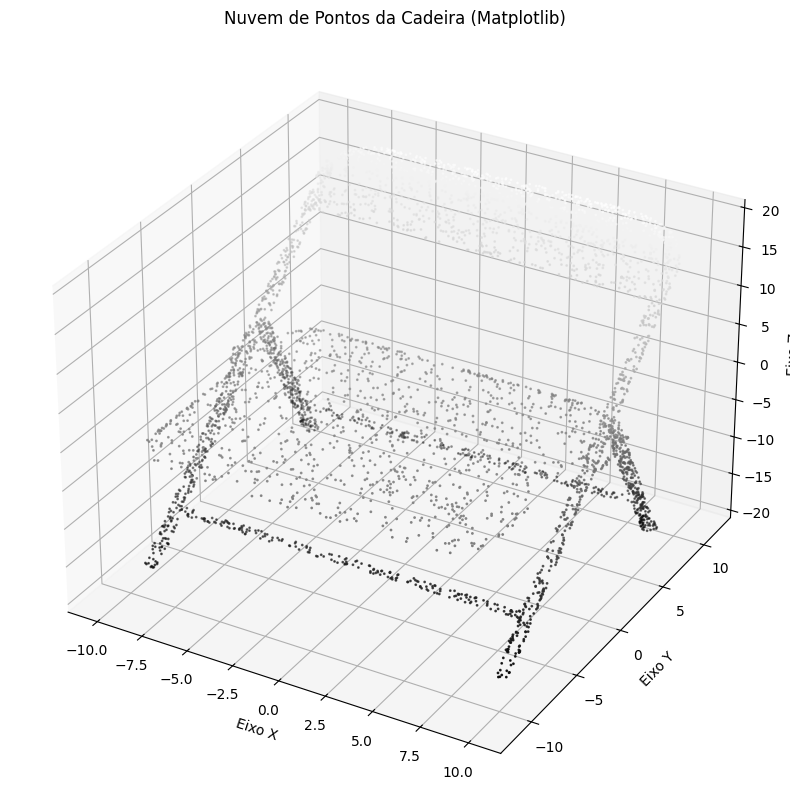

In [6]:
import open3d as o3d
from open3d.visualization import draw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessário para registrar a projeção 3D

# ============================================
# 📂 1. Carregar a Malha 3D (Mesh)
# ============================================

mesh_path = "/content//ModelNet10/ModelNet10/chair/train/chair_0001.off"
mesh = o3d.io.read_triangle_mesh(mesh_path)

if not mesh.has_vertices():
    print(f"❌ Erro: Não foi possível carregar a malha em {mesh_path}")
else:
    print(f"✅ Malha 3D carregada de {mesh_path}")

    # ============================================
    # ☁️ 2. Transformar Malha em Nuvem de Pontos
    # ============================================
    numero_de_pontos = 4160
    pcd = mesh.sample_points_uniformly(number_of_points=numero_de_pontos)

    print(f"✅ Malha convertida em Nuvem de Pontos com {len(pcd.points)} pontos.")

    # (ModelNet10 não tem cores, então este 'if' geralmente não é executado)
    if mesh.has_vertex_colors():
        pcd.colors = mesh.vertex_colors
    mesh.paint_uniform_color([0.5, 0.5, 0.5])
    # ============================================
    # 💾 3. Salvar a Nuvem de Pontos
    # ============================================
    output_pcd_path = "/content/pointcloud_gerada_da_malha.ply"
    o3d.io.write_point_cloud(output_pcd_path, pcd)

    print(f"💾 Nuvem de pontos salva em: {output_pcd_path}")

    # ============================================
    # 🎨 4. Visualizar com Matplotlib (Substituto do draw())
    # ============================================

    # Linha original comentada:
    # draw([pcd], title="Nuvem de Pontos Gerada da Malha")

    print("Gerando visualização 3D com Matplotlib...")

    # 4a. Converter a nuvem de pontos Open3D para um array NumPy
    points = np.asarray(pcd.points)

    # 4b. Extrair os eixos X, Y, Z
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # 4c. Criar a figura e o eixo 3D
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 4d. Plotar os pontos
    # s=1 define o tamanho do ponto (pequeno)
    # c=z colore os pontos de acordo com a altura (eixo Z)
    # cmap='viridis' é um bom mapa de cores para profundidade
    ax.scatter(x, y, z, s=1, c=z, cmap='gray')

    # 4e. Configurar títulos e rótulos
    ax.set_title("Nuvem de Pontos da Cadeira (Matplotlib)")
    ax.set_xlabel("Eixo X")
    ax.set_ylabel("Eixo Y")
    ax.set_zlabel("Eixo Z")

    # 4f. Ajustar a visualização para não distorcer (opcional)
    ax.set_aspect('auto') # 'auto' ou 'equal' (cuidado com 'equal' em 3D)

    # 4g. Mostrar o gráfico
    plt.show()

Fazendo a mesh com o point cloud gerado


✅ Nuvem de pontos carregada: 4160 pontos.
Iniciando cálculo de normais...
✅ Normais calculadas e orientadas.
Iniciando reconstrução de malha (Poisson)...
✅ Malha gerada.
✅ Malha limpa e suavizada. Triângulos: 29940
💾 Malha 3D reconstruída salva em: /content/malha_RECONSTRUIDA.ply
Gerando visualização 3D da Malha com Matplotlib...


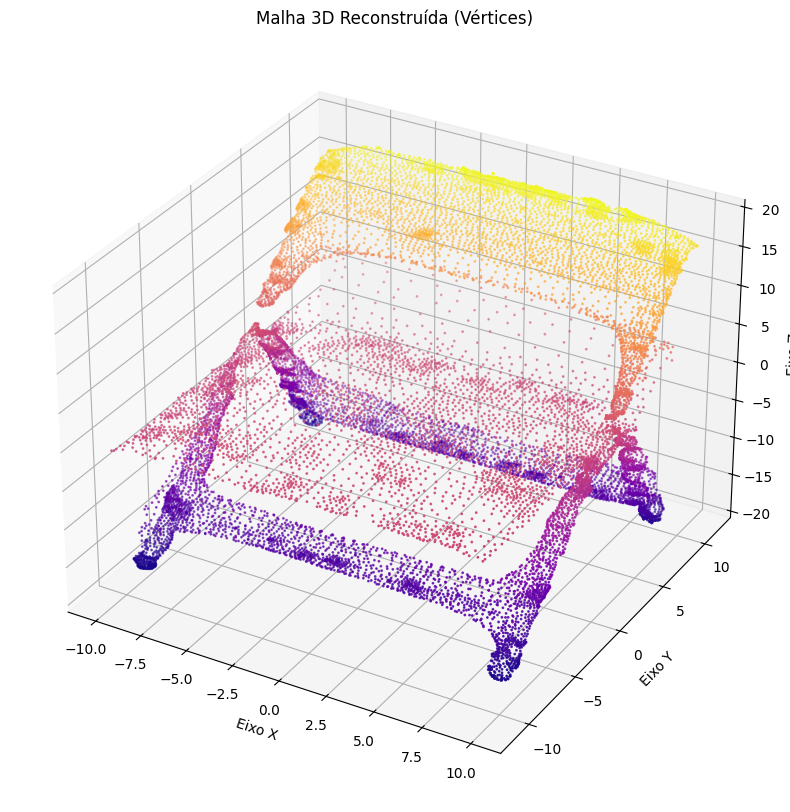

In [4]:
import open3d as o3d
import numpy as np
from open3d.visualization import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importação para projeção 3D

# ============================================
# ☁️ 1. Carregar a Nuvem de Pontos (Point Cloud)
# ============================================
# Usamos o arquivo que acabamos de salvar
pcd_path = "/content/pointcloud_gerada_da_malha.ply"
pcd = o3d.io.read_point_cloud(pcd_path)

if not pcd.has_points():
    print(f"❌ Erro: Não foi possível carregar a nuvem de pontos de {pcd_path}")
else:
    print(f"✅ Nuvem de pontos carregada: {len(pcd.points)} pontos.")

    # ============================================
    # 📐 2. Estimar Normais
    # ============================================
    print("Iniciando cálculo de normais...")
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=100)
    )
    pcd.orient_normals_consistent_tangent_plane(k=50)
    print("✅ Normais calculadas e orientadas.")

    # ============================================
    # ✨ 3. Reconstruir a Malha 3D (Poisson)
    # ============================================
    print("Iniciando reconstrução de malha (Poisson)...")
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, linear_fit=True
    )
    print("✅ Malha gerada.")

    # ============================================
    # ✂️ 4. Limpeza e Refinamento
    # ============================================
    bbox = pcd.get_axis_aligned_bounding_box()
    mesh_clean = mesh.crop(bbox)
    mesh_clean = mesh_clean.filter_smooth_simple(number_of_iterations=3)

    print(f"✅ Malha limpa e suavizada. Triângulos: {len(mesh_clean.triangles)}")

    # ============================================
    # 💾 5. Salvar e Visualizar com Matplotlib
    # ============================================
    output_mesh_path = "/content/malha_RECONSTRUIDA.ply"
    o3d.io.write_triangle_mesh(output_mesh_path, mesh_clean)

    print(f"💾 Malha 3D reconstruída salva em: {output_mesh_path}")

    # Linha original comentada:
    mesh_clean.paint_uniform_color([0.0, 0.8, 0.2]) # Cor verde
    # draw([mesh_clean], title="Malha 3D Reconstruída (Nível Bunny)")

    print("Gerando visualização 3D da Malha com Matplotlib...")

    # 5a. Converter os VÉRTICES da malha para NumPy
    # A malha é feita de vértices (pontos) e triângulos (faces)
    # Para uma visualização rápida, plotar os vértices é o suficiente
    vertices = np.asarray(mesh_clean.vertices)

    # 5b. Extrair os eixos X, Y, Z
    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]

    # 5c. Criar a figura e o eixo 3D
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 5d. Plotar os vértices
    # Usamos um 's' pequeno e 'c=z' para colorir por altura
    ax.scatter(x, y, z, s=1, c=z, cmap='plasma') # plasma é um bom mapa de cores

    # 5e. Configurar títulos e rótulos
    ax.set_title("Malha 3D Reconstruída (Vértices)")
    ax.set_xlabel("Eixo X")
    ax.set_ylabel("Eixo Y")
    ax.set_zlabel("Eixo Z")

    # 5f. Mostrar o gráfico
    plt.show()

Bloco para modelos externos

[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveNonManifoldEdges] This mesh contains triangle uvs that are not handled in this function
✅ Malha externa carregada e limpa: 7780 triângulos
✅ Malha externa convertida em nuvem de pontos.
Iniciando cálculo de normais...
Iniciando reconstrução Poisson...
✅ Malha externa reconstruída com alta qualidade!
💾 Malha refinada salva em: /content/modelo_externo_reconstruido.ply
Gerando visualização 3D lado-a-lado com Matplotlib...


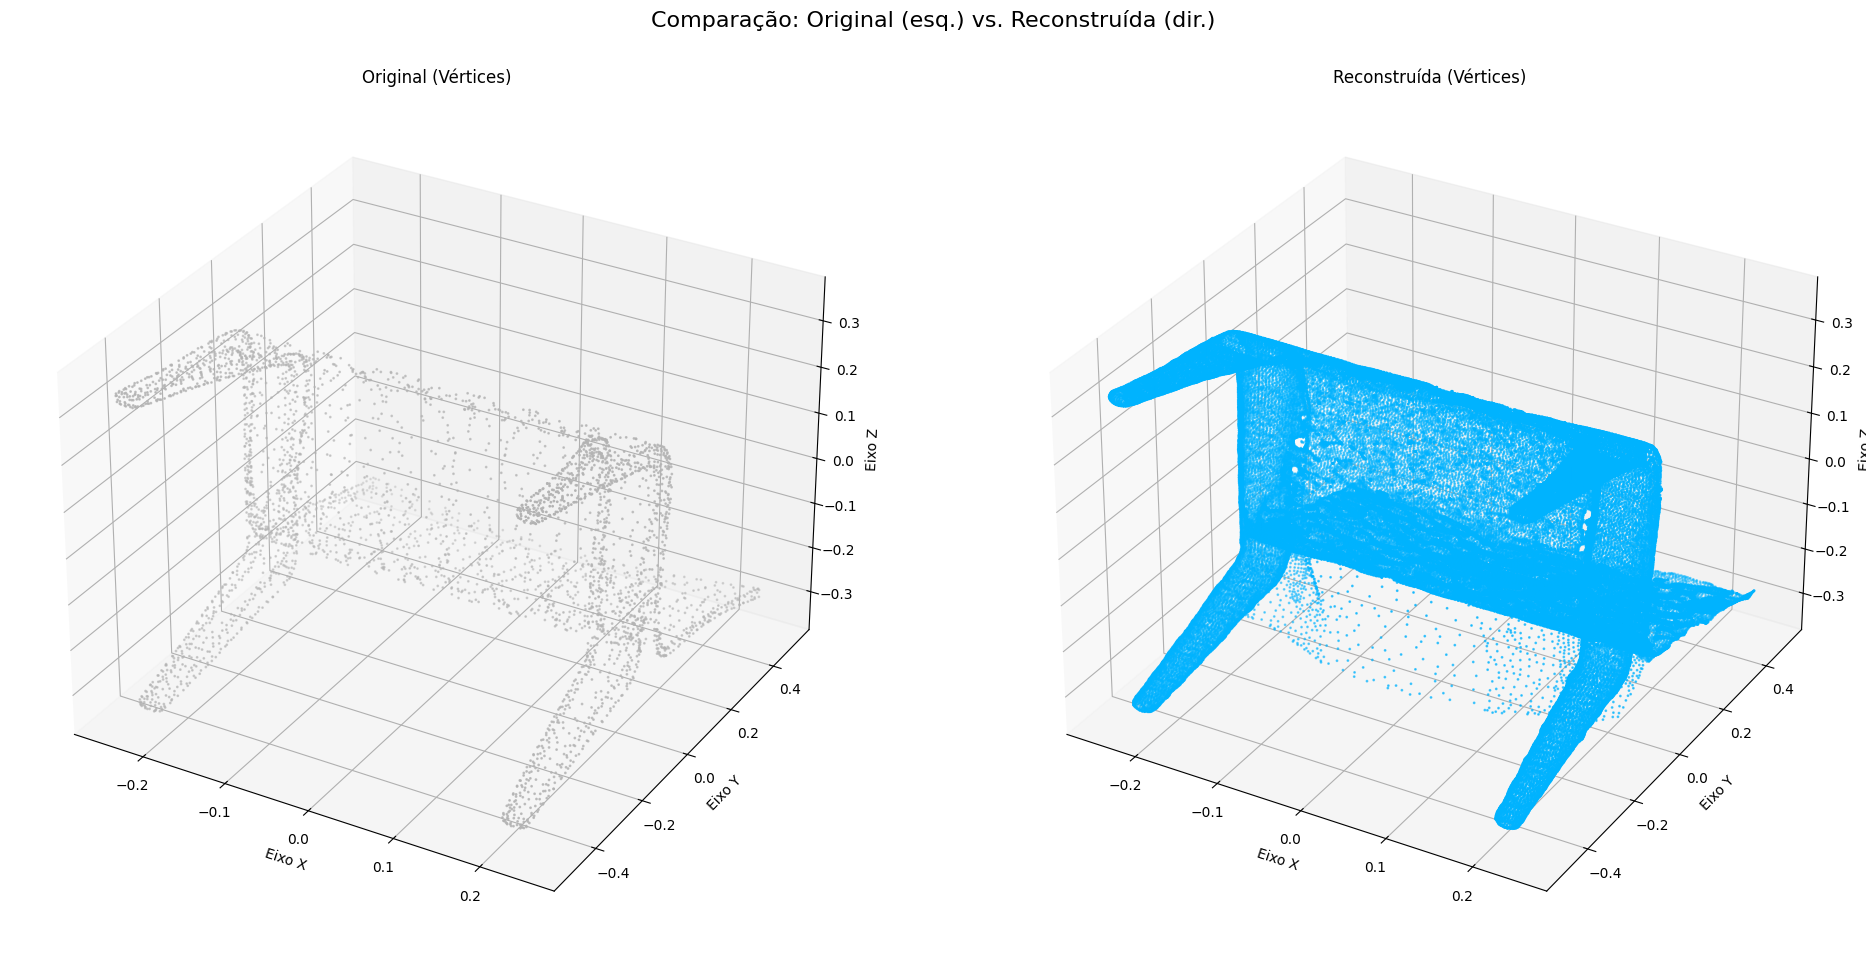

In [10]:
import open3d as o3d
import numpy as np
from open3d.visualization import draw

# ============================================
# 📂 1. Definir o Caminho do Modelo Externo
# ============================================
# !! MUDE AQUI !!
# Exemplo: "/content/meu_modelo.obj", "/content/bun_zipper.ply", etc.
external_file_path = "/content/sample (1).glb"

# ============================================
# 🌀 2. Carregar e Limpar Malha Externa
# ============================================
mesh_externo = o3d.io.read_triangle_mesh(external_file_path)

if not mesh_externo.has_vertices():
    print(f"❌ Erro: Não foi possível carregar a malha em {external_file_path}")
    print("Verifique o caminho ou se o formato é suportado (.obj, .ply, .stl, .off, .gltf)")
else:
    # Modelos externos podem ser "sujos". Vamos limpar primeiro.
    mesh_externo.remove_degenerate_triangles()
    mesh_externo.remove_duplicated_vertices()
    mesh_externo.remove_non_manifold_edges()
    mesh_externo.compute_vertex_normals()

    print(f"✅ Malha externa carregada e limpa: {len(mesh_externo.triangles)} triângulos")

    # ============================================
    # ☁️ 3. Converter em Nuvem de Pontos 360°
    # ============================================
    pcd_externo = mesh_externo.sample_points_uniformly(number_of_points=40000)
    print("✅ Malha externa convertida em nuvem de pontos.")

    # ============================================
    # ✨ 4. Reconstruir Malha (Pipeline Poisson)
    # ============================================
    print("Iniciando cálculo de normais...")
    pcd_externo.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.02, max_nn=50)
    )
    pcd_externo.orient_normals_consistent_tangent_plane(k=50)

    print("Iniciando reconstrução Poisson...")
    mesh_poisson_ext, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_externo, depth=8, linear_fit=True
    )

    bbox_ext = pcd_externo.get_axis_aligned_bounding_box()
    mesh_final_ext = mesh_poisson_ext.crop(bbox_ext)
    mesh_final_ext = mesh_final_ext.filter_smooth_simple(number_of_iterations=6)

    print("✅ Malha externa reconstruída com alta qualidade!")

    # ============================================
    # 💾 5. Salvar e Visualizar
    # ============================================
    output_path_ext = "/content/modelo_externo_reconstruido.ply"
    o3d.io.write_triangle_mesh(output_path_ext, mesh_final_ext)
    print(f"💾 Malha refinada salva em: {output_path_ext}")



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importação para projeção 3D
import numpy as np
import open3d as o3d
# (Assumindo que 'mesh_externo' e 'mesh_final_ext' já existem)

# ============================================
# 🎨 5. Visualizar com Matplotlib (Lado-a-Lado)
# ============================================

# Linhas originais comentadas:
# mesh_externo.paint_uniform_color([0.7, 0.7, 0.7])
# mesh_final_ext.paint_uniform_color([0.0, 0.7, 1.0]) # Azul
# draw([
#     mesh_externo.translate((-1.0, 0, 0)), # Original na esquerda
#     mesh_final_ext.translate((1.0, 0, 0))  # Reconstruída na direita
# ], title="Comparação: Original (esq.) vs. Reconstruída (dir.)")

print("Gerando visualização 3D lado-a-lado com Matplotlib...")

# 1. Obter os vértices das duas malhas como arrays NumPy
verts_orig = np.asarray(mesh_externo.vertices)
verts_recon = np.asarray(mesh_final_ext.vertices)

# 2. Definir as cores (as mesmas que você tinha)
color_orig = [0.7, 0.7, 0.7] # Cinza
color_recon = [0.0, 0.7, 1.0] # Azul

# 3. Criar a figura e os subplots
# Criamos uma figura larga (20x10) para caber os dois gráficos
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Comparação: Original (esq.) vs. Reconstruída (dir.)", fontsize=16)

# --- Plot 1: Malha Original (Esquerda) ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(
    verts_orig[:, 0],  # X
    verts_orig[:, 1],  # Y
    verts_orig[:, 2],  # Z
    s=1,               # Tamanho do ponto
    c=[color_orig]     # Cor Cinza (dentro de uma lista)
)
ax1.set_title("Original (Vértices)")
ax1.set_xlabel("Eixo X"); ax1.set_ylabel("Eixo Y"); ax1.set_zlabel("Eixo Z")
ax1.set_aspect('auto') # Ajusta o aspecto

# --- Plot 2: Malha Reconstruída (Direita) ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(
    verts_recon[:, 0], # X
    verts_recon[:, 1], # Y
    verts_recon[:, 2], # Z
    s=1,               # Tamanho do ponto
    c=[color_recon]    # Cor Azul (dentro de uma lista)
)
ax2.set_title("Reconstruída (Vértices)")
ax2.set_xlabel("Eixo X"); ax2.set_ylabel("Eixo Y"); ax2.set_zlabel("Eixo Z")
ax2.set_aspect('auto')

# 4. Mostrar os gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o título
plt.show()

#Agora, tentando gerar um mesh com imagem 2d pra competir.

✅ Bibliotecas 'diffusers' e 'transformers' instaladas.
Carregando pipeline do Shap-E (isso baixará os pesos)...


The config attributes {'renderer': ['shap_e', 'ShapERenderer']} were passed to ShapEImg2ImgPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'renderer': ['shap_e', 'ShapERenderer']} are not expected by ShapEImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--openai--shap-e-img2img/snapshots/0e0aba80f08d368aaf6af9cb93583707481cc29b/shap_e_renderer: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--openai--shap-e-img2img/snapshots/0e0aba80f08d368aaf6af9cb93583707481cc29b/shap_e_renderer.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--openai--shap-e-img2img/snapshots/0e0aba80f08d368aaf6af9cb93583707481cc29b/prior: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--openai--shap-e-img2img/snapshots/0e0aba80f08d368aaf6af9cb93583707481cc29b/prior.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✅ Pipeline Shap-E (Img2Img) carregado em: cuda
✅ Imagem carregada: /content/wooden-chair-dining-ywYA5RF-600.jpg
Iniciando geração de malha 3D (IA Generativa)...


  0%|          | 0/127 [00:00<?, ?it/s]

✅ Malha 3D gerada pela IA!
💾 Malha 3D completa salva em: /content/malha_3D_gerada_pelo_Diffusers.ply
Gerando visualização 3D com Matplotlib...


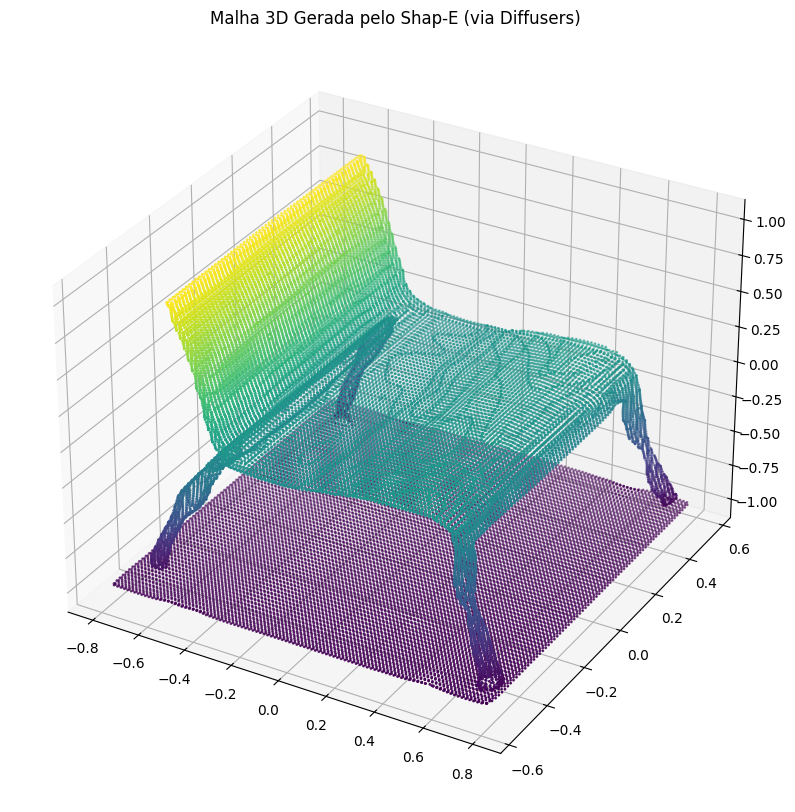

In [8]:
# ============================================
# 🧱 1. Instalação (A Forma Correta)
# ============================================
# 'diffusers' é uma biblioteca padrão que instala limpo
!pip install diffusers transformers accelerate

print("✅ Bibliotecas 'diffusers' e 'transformers' instaladas.")

# ============================================
# 🧠 2. Importar e Carregar o Modelo de IA (Corrigido)
# ============================================
import torch
from diffusers import ShapEImg2ImgPipeline  # <-- MUDANÇA AQUI
from diffusers.utils import export_to_ply
from PIL import Image
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("Carregando pipeline do Shap-E (isso baixará os pesos)...")

# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carrega o pipeline de Imagem-para-3D (Img2Img)
pipe = ShapEImg2ImgPipeline.from_pretrained(  # <-- MUDANÇA AQUI
    "openai/shap-e-img2img",
    torch_dtype=torch.float16
)
pipe = pipe.to(device)
print(f"✅ Pipeline Shap-E (Img2Img) carregado em: {device}")
# ============================================
# 🖼️ 3. Carregar a Imagem 2D de Input
# ============================================
image_path = "/content/wooden-chair-dining-ywYA5RF-600.jpg"

try:
    # O Shap-E (via diffusers) prefere imagens PNG com fundo transparente
    # Mas vamos tentar com a sua imagem JPG primeiro.
    input_image = Image.open(image_path)
    print(f"✅ Imagem carregada: {image_path}")
except FileNotFoundError:
    print(f"❌ Erro: Imagem não encontrada em {image_path}")

# ============================================
# 🚀 4. GERAR A MALHA 3D
# ============================================
print("Iniciando geração de malha 3D (IA Generativa)...")

# 'guidance_scale' controla o quão fiel à imagem ele é
# 'output_type="mesh"' nos dá a malha diretamente
with torch.no_grad():
    output = pipe(
        input_image,
        guidance_scale=3.0,
        num_inference_steps=64,
        frame_size=256,
        output_type="mesh"
    )

mesh_output = output.images[0]
print("✅ Malha 3D gerada pela IA!")

# ============================================
# 💾 5. Salvar a Malha 3D
# ============================================
output_mesh_path = "/content/malha_3D_gerada_pelo_Diffusers.ply"

# A 'diffusers' tem uma função própria para salvar o PLY
export_to_ply(mesh_output, output_mesh_path)

print(f"💾 Malha 3D completa salva em: {output_mesh_path}")

# ============================================
# 🎨 6. Visualizar com Matplotlib (Estável)
# ============================================
print("Gerando visualização 3D com Matplotlib...")

mesh_o3d = o3d.io.read_triangle_mesh(output_mesh_path)
mesh_o3d.compute_vertex_normals()

vertices = np.asarray(mesh_o3d.vertices)
x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1, c=z, cmap='viridis')
ax.set_title("Malha 3D Gerada pelo Shap-E (via Diffusers)")
plt.show()

🚀 Iniciando pipeline de Refinamento de Malha (Pós-IA)...
✅ Malha da IA carregada e limpa: 82012 triângulos
✅ Malha da IA convertida em nuvem de pontos.
Iniciando cálculo de normais...
Iniciando reconstrução Poisson (depth=8 para suavizar)...
✅ Malha da IA reconstruída e refinada!
💾 Malha refinada salva em: /content/malha_3D_IA_REFINADA.ply
Gerando visualização 3D lado-a-lado (Original IA vs. Refinada)...


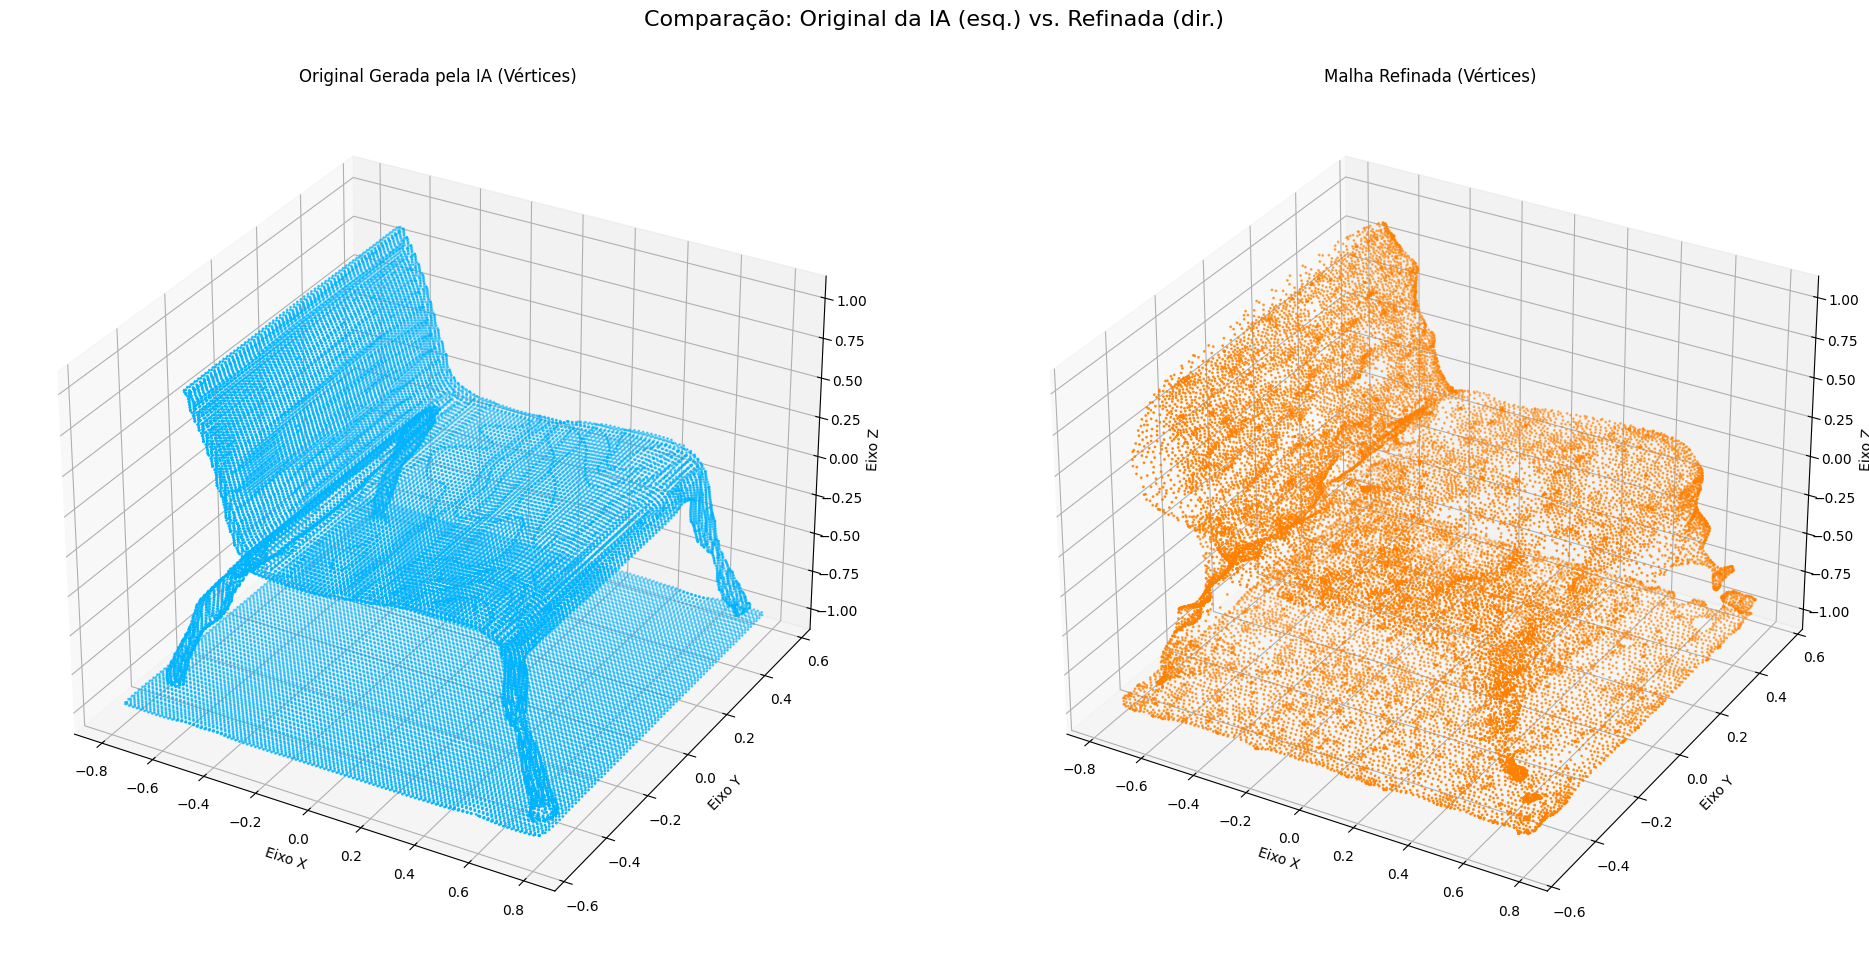

In [9]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importação para projeção 3D
import os

print("🚀 Iniciando pipeline de Refinamento de Malha (Pós-IA)...")

# ============================================
# 📂 1. Definir o Caminho do Modelo (Gerado pela IA)
# ============================================
# Este é o arquivo que o Shap-E (diffusers) acabou de criar
input_mesh_path = "/content/malha_3D_gerada_pelo_Diffusers.ply"

# ============================================
#  2. Carregar e Limpar Malha Original (da IA)
# ==========================================
mesh_ia_original = o3d.io.read_triangle_mesh(input_mesh_path)

if not mesh_ia_original.has_vertices():
    print(f"❌ Erro: Não foi possível carregar a malha em {input_mesh_path}")
    print("Certifique-se de que o pipeline do Shap-E rodou primeiro.")
else:
    # Limpeza padrão
    mesh_ia_original.remove_degenerate_triangles()
    mesh_ia_original.remove_duplicated_vertices()
    mesh_ia_original.remove_non_manifold_edges()
    mesh_ia_original.compute_vertex_normals()

    print(f"✅ Malha da IA carregada e limpa: {len(mesh_ia_original.triangles)} triângulos")

    # ============================================
    #  3. Converter em Nuvem de Pontos 360°
    # ============================================
    # Usando os mesmos parâmetros do seu código
    pcd_ia = mesh_ia_original.sample_points_uniformly(number_of_points=8000)
    print("✅ Malha da IA convertida em nuvem de pontos.")

    # ============================================
    # ✨ 4. Reconstruir Malha (Pipeline Poisson para Suavização)
    # ============================================
    print("Iniciando cálculo de normais...")
    pcd_ia.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.02, max_nn=100)
    )
    pcd_ia.orient_normals_consistent_tangent_plane(k=50)

    print("Iniciando reconstrução Poisson (depth=8 para suavizar)...")
    # Usar 'depth=8' (como no seu código) é perfeito aqui
    # porque age como um filtro de suavização, removendo o ruído da IA.
    mesh_poisson_ia, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_ia, depth=8, linear_fit=True
    )

    bbox_ia = pcd_ia.get_axis_aligned_bounding_box()
    mesh_ia_reconstruida = mesh_poisson_ia.crop(bbox_ia)
    mesh_ia_reconstruida = mesh_ia_reconstruida.filter_smooth_simple(number_of_iterations=6)

    print("✅ Malha da IA reconstruída e refinada!")

    # ============================================
    # 💾 5. Salvar e Visualizar
    # ============================================
    output_path_refinada = "/content/malha_3D_IA_REFINADA.ply"
    o3d.io.write_triangle_mesh(output_path_refinada, mesh_ia_reconstruida)
    print(f"💾 Malha refinada salva em: {output_path_refinada}")

    # ============================================
    # 🎨 6. Visualizar com Matplotlib (Lado-a-Lado)
    # ============================================
    print("Gerando visualização 3D lado-a-lado (Original IA vs. Refinada)...")

    # 6a. Obter os vértices das duas malhas
    verts_orig = np.asarray(mesh_ia_original.vertices)
    verts_recon = np.asarray(mesh_ia_reconstruida.vertices)

    # 6b. Definir as cores
    color_orig = [0.0, 0.7, 1.0] # Azul (O original da IA)
    color_recon = [1.0, 0.5, 0.0] # Laranja (O refinado)

    # 6c. Criar a figura e os subplots
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle("Comparação: Original da IA (esq.) vs. Refinada (dir.)", fontsize=16)

    # --- Plot 1: Original da IA (Esquerda) ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(
        verts_orig[:, 0], verts_orig[:, 1], verts_orig[:, 2],
        s=1, c=[color_orig]
    )
    ax1.set_title("Original Gerada pela IA (Vértices)")
    ax1.set_xlabel("Eixo X"); ax1.set_ylabel("Eixo Y"); ax1.set_zlabel("Eixo Z")
    ax1.set_aspect('auto')

    # --- Plot 2: Malha Refinada (Direita) ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(
        verts_recon[:, 0], verts_recon[:, 1], verts_recon[:, 2],
        s=1, c=[color_recon]
    )
    ax2.set_title("Malha Refinada (Vértices)")
    ax2.set_xlabel("Eixo X"); ax2.set_ylabel("Eixo Y"); ax2.set_zlabel("Eixo Z")
    ax2.set_aspect('auto')

    # 6d. Mostrar os gráficos
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()